In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")

fatal: destination path 'LightGlue' already exists and is not an empty directory.


/home/mtronlab/priyansh/mr_proj/KITTI_visual_odometry/LightGlue


In [2]:

import torch
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import datetime
import numpy as np


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

# extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
# matcher = LightGlue(features="superpoint").eval().to(device)
device

device(type='cuda')

In [4]:
ls

assets/       LICENSE              pyproject.toml    trajectory_lightglue1.csv
benchmark.py  lightglue/           README.md         trajectory_lightglue.csv
demo.ipynb    lightglue.egg-info/  requirements.txt


In [5]:
poses = pd.read_csv('../../KITTI_visual_odometry/dataset/poses/00.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)
poses.head()

Shape of position dataframe: (4541, 12)


0             1             2             3             4         5   \
0  1.000000  9.043680e-12  2.326809e-11  5.551115e-17  9.043683e-12  1.000000   
1  0.999998  5.272628e-04 -2.066935e-03 -4.690294e-02 -5.296506e-04  0.999999   
2  0.999991  1.048972e-03 -4.131348e-03 -9.374345e-02 -1.058514e-03  0.999997   
3  0.999980  1.566466e-03 -6.198571e-03 -1.406429e-01 -1.587952e-03  0.999993   
4  0.999964  2.078471e-03 -8.263498e-03 -1.874858e-01 -2.116664e-03  0.999987   

             6             7             8             9         10  \
0  2.392370e-10  3.330669e-16  2.326810e-11  2.392370e-10  1.000000   
1 -1.154865e-03 -2.839928e-02  2.066324e-03  1.155958e-03  0.999997   
2 -2.308104e-03 -5.676064e-02  4.128913e-03  2.312456e-03  0.999989   
3 -3.462706e-03 -8.515762e-02  6.193102e-03  3.472479e-03  0.999975   
4 -4.615826e-03 -1.135202e-01  8.253797e-03  4.633149e-03  0.999955   

             11  
0 -4.440892e-16  
1  8.586941e-01  
2  1.716275e+00  
3  2.574964e+00  
4  3.432648e+00

In [6]:
type(poses)

pandas.core.frame.DataFrame

In [7]:
#rotational component is identity, with a translation vector equal to zero for all axes.

first_pose = np.array(poses.iloc[0]).reshape((3,4)).round(2)
print("first_pose", first_pose)
second_pose = np.array(poses.iloc[1]).reshape((3,4)).round(2)
print("second_pose", second_pose)

first_pose [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1. -0.]]
second_pose [[ 1.    0.   -0.   -0.05]
 [-0.    1.   -0.   -0.03]
 [ 0.    0.    1.    0.86]]


In [8]:
gt = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))

In [9]:
#gt[1].dot(np.array([0,0,0,1]))
gt[0]

array([[ 1.000000e+00,  9.043680e-12,  2.326809e-11,  5.551115e-17],
       [ 9.043683e-12,  1.000000e+00,  2.392370e-10,  3.330669e-16],
       [ 2.326810e-11,  2.392370e-10,  9.999999e-01, -4.440892e-16]])

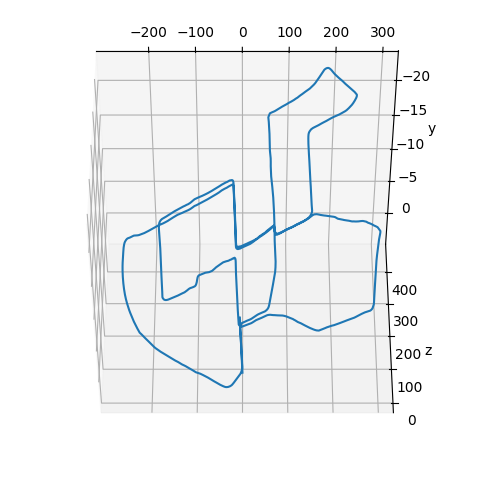

In [10]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

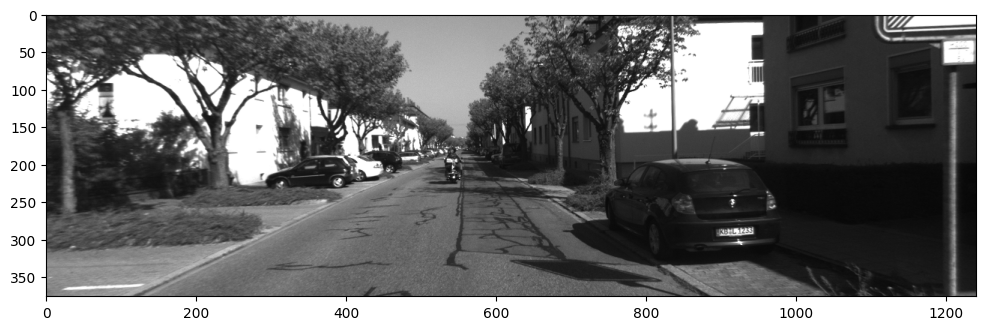

In [11]:
test_img = cv2.imread('../../KITTI_visual_odometry/dataset/sequences/00/image_0/000000.png')
plt.figure(figsize=(12,6))
plt.imshow(test_img)
#print(type(test_img))

In [12]:
times = pd.read_csv('../../KITTI_visual_odometry/dataset/sequences/00/times.txt', delimiter=' ', header=None)
times.head()

0
0  0.000000
1  0.103736
2  0.207338
3  0.311075
4  0.414692

In [13]:

image_files = os.listdir('../../KITTI_visual_odometry/dataset/sequences/00/image_0')


print("imgs, poses",len(image_files),len(poses) )

imgs, poses 4541 4541


In [14]:
# load sensor calibration data
calib = pd.read_csv('../../KITTI_visual_odometry/dataset/sequences/00/calib.txt', delimiter=' ', header=None, index_col=0)
calib

1         2           3           4         5           6   \
0                                                                         
P0:  718.856000  0.000000  607.192800    0.000000  0.000000  718.856000   
P1:  718.856000  0.000000  607.192800 -386.144800  0.000000  718.856000   
P2:  718.856000  0.000000  607.192800   45.382250  0.000000  718.856000   
P3:  718.856000  0.000000  607.192800 -337.287700  0.000000  718.856000   
Tr:    0.000428 -0.999967   -0.008084   -0.011985 -0.007211    0.008081   

             7         8         9         10        11        12  
0                                                                  
P0:  185.215700  0.000000  0.000000  0.000000  1.000000  0.000000  
P1:  185.215700  0.000000  0.000000  0.000000  1.000000  0.000000  
P2:  185.215700 -0.113089  0.000000  0.000000  1.000000  0.003780  
P3:  185.215700  2.369057  0.000000  0.000000  1.000000  0.004915  
Tr:   -0.999941 -0.054040  0.999974  0.000486 -0.007207 -0.292197

In [15]:
# P0 is the projection matrix left grayscale camera
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

In [16]:
# Decomposing a projection matrix with OpenCV
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix:')
print(k1)
print('Rotation Matrix:')
print(r1)
print('Translation Vector:')
print(t1.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


In [17]:
test_img.shape

(376, 1241, 3)

In [18]:
cx = k1[0,2]
cy = k1[1,2]
print('Actual center of image (x, y):', (test_img.shape[1]/2, test_img.shape[0]/2))
print('Optical center of image (cx, cy)', (cx, cy))

Actual center of image (x, y): (620.5, 188.0)
Optical center of image (cx, cy) (607.1928, 185.2157)


# Datahandler

In [19]:
class Dataset_Handler():
    def __init__(self, sequence, progress_bar=True, low_memory=True):
        import pandas as pd
        import os
        import cv2
        
        # This will tell odometry function how to access data from this object
        self.low_memory = low_memory
        
        # Set file paths and get ground truth poses
        self.seq_dir = '../../KITTI_visual_odometry/dataset/sequences/{}/'.format(sequence)
        self.poses_dir = '../../KITTI_visual_odometry/dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        # Get names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.left_image_files= sorted(self.left_image_files)
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.right_image_files= sorted(self.right_image_files) #####to rectify random sequences###
        self.num_frames = len(self.left_image_files)
        
        # Get calibration details for scene
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        
        # Get times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', 
                                          delimiter=' ', 
                                          header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        # Get images loaded
        
        # Will use generators to provide data sequentially to save RAM
        # Use class method to set up generators
        self.reset_frames()
        # Store original frame to memory for testing functions
        self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                            + self.left_image_files[0])
        self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                            + self.right_image_files[0])
        self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                            + self.left_image_files[1])
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
            
        
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right)
                            for name_right in self.right_image_files)
        pass


In [20]:
#image_path_list = glob(dataset_path)
#image_path_list = sorted(image_path_list)

In [21]:
handler = Dataset_Handler('00')

In [22]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    
  
    sad_window = 6  #tuning.
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

(376, 1241, 3)

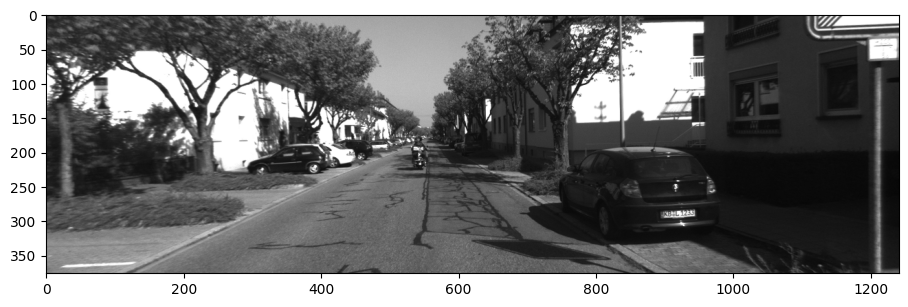

In [23]:
plt.figure(figsize=(11,7))
plt.imshow(handler.first_image_left);
handler.first_image_left.shape

Time to compute disparity map using StereoBM: 0:00:00.010384


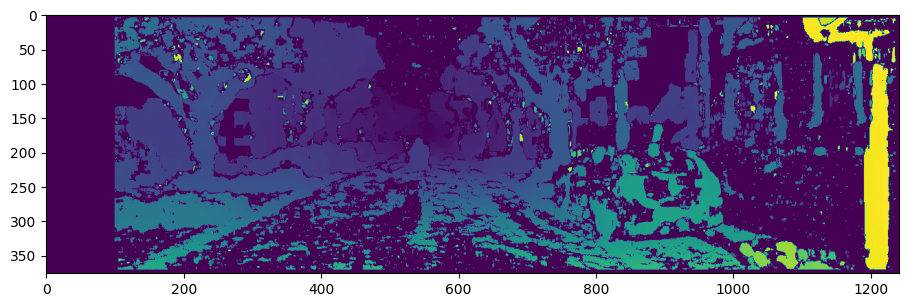

In [24]:
im_left=gray_image_left = cv2.cvtColor(handler.first_image_left, cv2.COLOR_BGR2GRAY)
im_right=gray_image_right = cv2.cvtColor(handler.first_image_right, cv2.COLOR_BGR2GRAY)

disp = compute_left_disparity_map(im_left, 
                                  im_right, 
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)

Time to compute disparity map using StereoSGBM: 0:00:00.030400


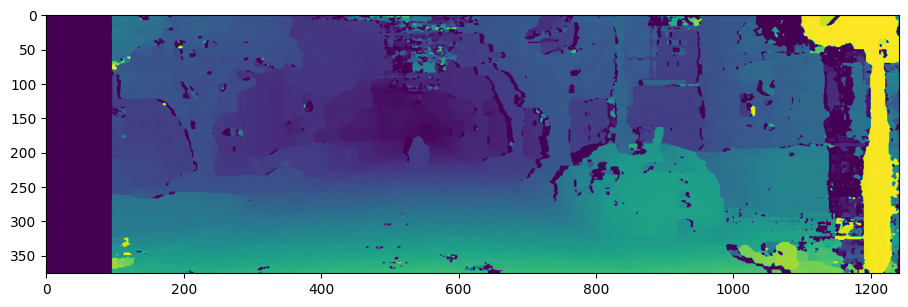

In [25]:
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

In [26]:
def decompose_projection_matrix(p):
   
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t


In [27]:
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [28]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

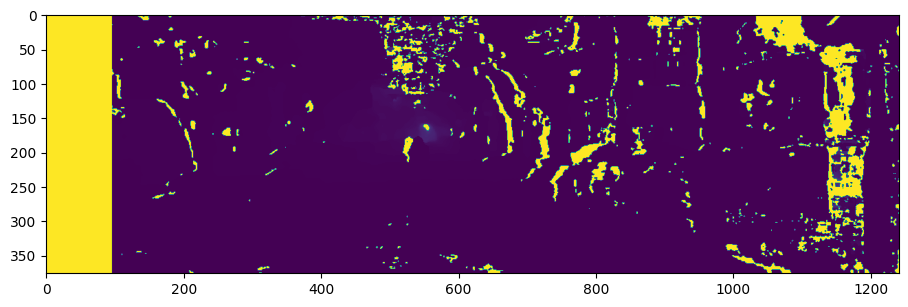

In [29]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth);

3861.447942459941 3861.447942459941 [3861.448]


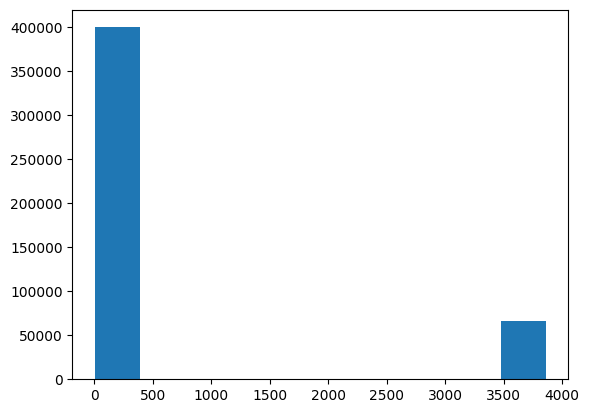

In [30]:
print(depth[0,0], depth.max(), k_left[0][0] * (t_right[0] - t_left[0]) / 0.1)
plt.hist(depth.flatten());

In [31]:
for i, pixel in enumerate(depth[4]):
    if pixel < depth.max():
        print('First non-max value at index', i)
        break

First non-max value at index 96


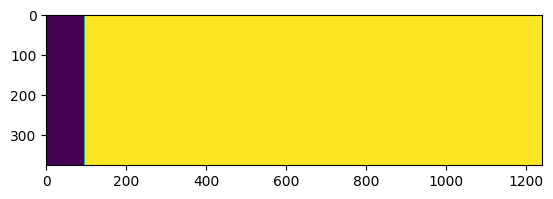

In [32]:
# We can constuct a mask using this information like so
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda')

In [34]:
# Let's make an all-inclusive function to get the depth from an incoming set of stereo images
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):

    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    

    return depth
    
    #return depth

# feature matching

In [35]:
ls

assets/       LICENSE              pyproject.toml    trajectory_lightglue1.csv
benchmark.py  lightglue/           README.md         trajectory_lightglue.csv
demo.ipynb    lightglue.egg-info/  requirements.txt


In [122]:
import numpy as np

def light_glued(image0,image1,dist_thres=20):


    extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
    matcher = LightGlue(features="superpoint").eval().to(device)
    
    
    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    
 
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

   
    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    print(matches.shape)
    #matches= matches.cpu().numpy()

    # m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    # filtered_matches = []
    # for i, match in enumerate(matches):
    #     if match[0] < dist_thres* match[1]:    
    #         filtered_matches.append(match)

    #thresholding 
    # m_distances = torch.norm(kpts0[matches[0, 0]] - kpts1[matches[0, 1]], dim=1)
    # m_distances = torch.norm(kpts0[matches[0, 0]] - kpts1[matches[1, 1]], dim=1)
    distances = torch.norm(kpts0[matches[..., 0]] - kpts1[matches[..., 1]], dim=1)
  
    #filtered_matches = filtered_matches

    # Set a distance threshold (you can adjust this value)

    # Filter matches based on the distance threshold
    filtered_matches = matches[distances < dist_thres] 
   
    # Extract the matched keypoints after filtering
    m_kpts0 = kpts0[filtered_matches[..., 0]]
    m_kpts1 = kpts1[filtered_matches[..., 1]]
 

    # axes = viz2d.plot_images([image0, image1])
    # viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
    # viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

    # kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
    # viz2d.plot_images([image0, image1])
    # viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)


    #return m_kpts0,m_kpts1,matches
    return m_kpts0.cpu().numpy(), m_kpts1.cpu().numpy(), filtered_matches.cpu().numpy()

In [123]:
print((handler.first_image_left).shape)
type(handler.first_image_left)

(376, 1241, 3)


numpy.ndarray

In [124]:
class og_KITTI_Dataset(torch.utils.data.Dataset):
  
    def __init__(self, image_paths, transforms):
        super().__init__()
        self.image_paths = image_paths
        self.transforms= transforms
      

    def __len__(self):
        return len(self.image_paths) - 1

    def __getitem__(self, idx):
        image_path_0 = self.image_paths[idx]
        image_path_1 = self.image_paths[idx+1]

        image_0 = Image.open(image_path_0)#.convert("L")  # Convert to grayscale
        image_1 = Image.open(image_path_1)#.convert("L")
        if self.transforms:
            image_0 = self.transforms(image_0)
            image_1 = self.transforms(image_1)

        return image_0, image_1

In [125]:
def estimate_motion(kp1, kp2, k, depth1=None, max_depth=3500):   #match, agrs
   

    
    image1_points = kp1
    image2_points = kp2
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    #print('elemennt iof KKKKK', k.shape)
    
    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        

        # for i in range(image1_points.shape[0]):
        #     print( 'sample', image1_points[i])
        #     u, v = image1_points[i]
       
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
       
            if z > max_depth:  
                delete.append(i)
                continue
            

            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            
        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
      
        if len(image1_points)>4:
            _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        
            rmat = cv2.Rodrigues(rvec)[0]
    
    return rmat, tvec, image1_points, image2_points

In [126]:
from glob import glob
from PIL import Image 
import torchvision.transforms as transforms


In [148]:
loaded_trajectry = np.loadtxt('../trajectory.csv', delimiter=',')
loaded_trajectry = loaded_trajectry.reshape(4541,3,4)

In [127]:
def visual_odometry(handler, stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
    

    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
      
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    # print('intrinsic', k_left.shape, k_left)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)

    #pytorch dataloader process    
    
    image_path_list1 = glob('../../KITTI_visual_odometry/dataset/sequences/00/image_0/*.png')
    image_path_list1 = sorted(image_path_list1)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts PIl to tensor
    ])

    torch_load = og_KITTI_Dataset(image_path_list1, transform)
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        
        start = datetime.datetime.now()
        # Get our stereo images for depth estimation
        if handler.low_memory:
            image_left = image_plus1
            image_right = next(handler.images_right)
            # Get next frame in the left camera for visual odometry
            image_plus1 = next(handler.images_left)
        else:
            image_left = handler.images_left[i]
            image_right = handler.images_right[i]
            # Get next frame in the left camera for visual odometry
            image_plus1 = handler.images_left[i+1]
            
        gray_image_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)
        gray_image_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)
       
        if depth_type == 'stereo':
            depth = stereo_2_depth(gray_image_left, 
                                   gray_image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
    
       
        
        
        image_left_new = torch_load[i][0]
        image_plus1_new = torch_load[i][1]
        #print(type(image_left_new))
        

        kpt0,kpt1,matches = light_glued(image_left_new,image_plus1_new)
        #print("done till lightglue")   
        #print('keyp', matches.shape, type(matches))
        #depth_tensor = torch.tensor(depth, dtype=torch.float32, device=device)
        #Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion( kpt0,kpt1, k_left, depth) #matches, args
        print("done till estimatemotion")  
        Tmat = np.eye(4)
        # Place resulting rotation matrix  and translation vector in their proper locations
        # in homogeneous T matrix
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        if (i%1000)== 0 or i==num_frames-1:
            np.savetxt('trajectory_lightglue1.csv', trajectory.reshape(-1, trajectory.shape[-1]), delimiter=',')

        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
        
    return trajectory

In [128]:
start = datetime.datetime.now()
trajectory_nolidar_bm = visual_odometry(handler,
                                        stereo_matcher='sgbm',
                                        mask=mask,     
                                        subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

torch.Size([997, 2])
done till estimatemotion
Time to compute frame 1: 0:00:00.140696
torch.Size([1047, 2])
done till estimatemotion
Time to compute frame 2: 0:00:00.140454
torch.Size([1082, 2])
done till estimatemotion
Time to compute frame 3: 0:00:00.143553
torch.Size([1094, 2])
done till estimatemotion
Time to compute frame 4: 0:00:00.141567
torch.Size([1105, 2])
done till estimatemotion
Time to compute frame 5: 0:00:00.148461
torch.Size([1099, 2])
done till estimatemotion
Time to compute frame 6: 0:00:00.142305
torch.Size([1126, 2])
done till estimatemotion
Time to compute frame 7: 0:00:00.134859
torch.Size([1098, 2])
done till estimatemotion
Time to compute frame 8: 0:00:00.139947
torch.Size([1125, 2])
done till estimatemotion
Time to compute frame 9: 0:00:00.141580
torch.Size([1139, 2])
done till estimatemotion
Time to compute frame 10: 0:00:00.141174
torch.Size([1132, 2])
done till estimatemotion
Time to compute frame 11: 0:00:00.133771
torch.Size([1138, 2])
done till estimatemo

In [129]:
#np.savetxt('trajectory_lightglue1.csv', trajectory_nolidar_bm.reshape(-1, trajectory_nolidar_bm.shape[-1]), delimiter=',')
#np.savetxt('trajectory_lightglue2.csv', trajectory_nolidar_bm.reshape(-1, trajectory_nolidar_bm.shape[-1]), delimiter=',')

In [142]:
loaded_trajectory = np.loadtxt('trajectory_lightglue1.csv', delimiter=',')
loaded_trajectory = loaded_trajectory.reshape(4541,3,4)

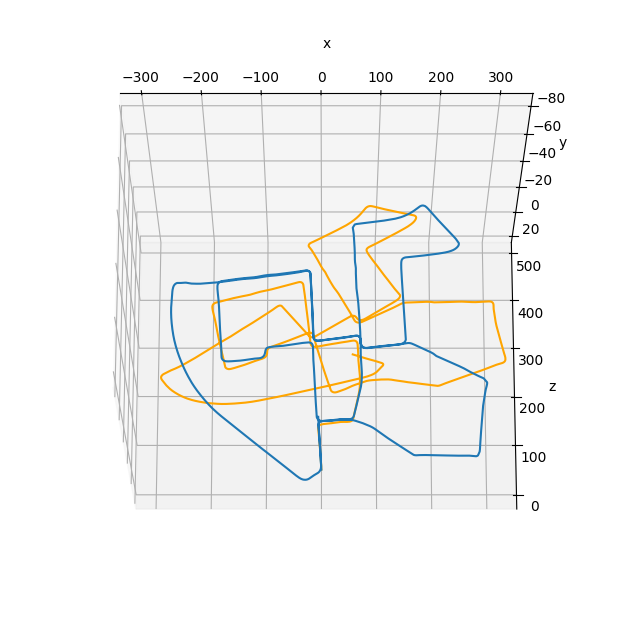

In [149]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(loaded_trajectry[:, :, 3][:, 0], 
        loaded_trajectry[:, :, 3][:, 1], 
        loaded_trajectry[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [150]:

def calculate_error(ground_truth, estimated, error_type='mse'):
    
    # Find the number of frames in the estimated trajectory to compare with
    nframes_est = estimated.shape[0]-1
    
    def get_mse(ground_truth, estimated):
        se = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)**2
        mse = se.mean()
        return mse
    
    def get_mae(ground_truth, estimated):
        ae = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)
        mae = ae.mean()
        return mae
    
    if error_type == 'mae':
        return get_mae(ground_truth, estimated)
    elif error_type == 'mse':
        return get_mse(ground_truth, estimated)
    elif error_type == 'rmse':
        return np.sqrt(get_mse(ground_truth, estimated))
    elif error_type == 'all':
        mae = get_mae(ground_truth, estimated)
        mse = get_mse(ground_truth, estimated)
        rmse = np.sqrt(mse)
        return {'mae': mae,
                'rmse': rmse,
                'mse': mse}

In [151]:
calculate_error(handler.gt, loaded_trajectory, 'all')

{'mae': 97.1873684792444, 'rmse': 97.18736893789945, 'mse': 9445.384681071384}

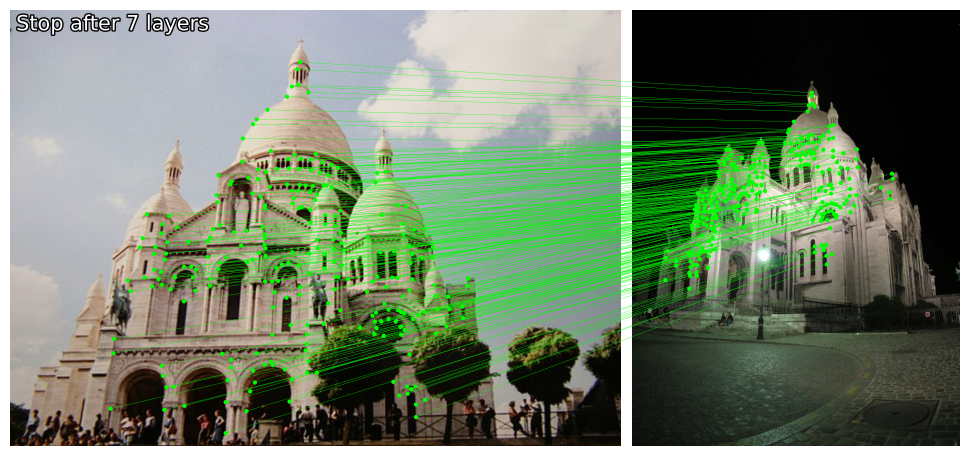

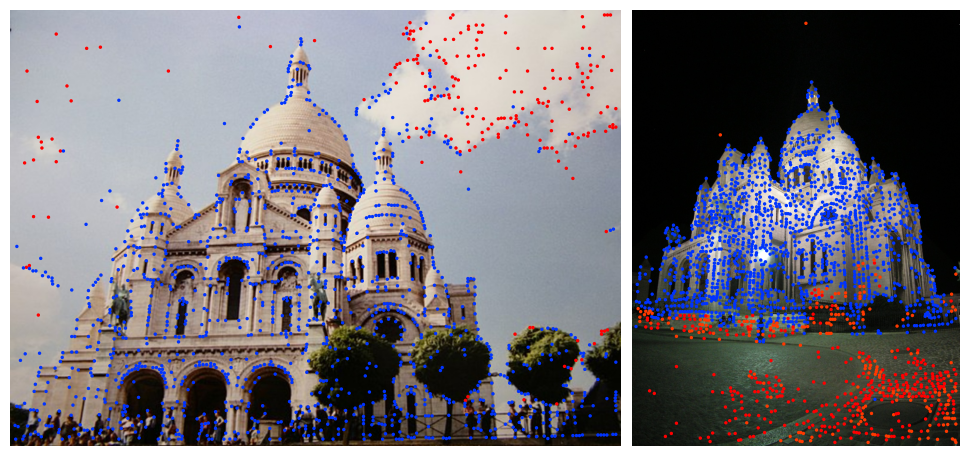

In [9]:
# image0 = load_image(images / "sacre_coeur1.jpg")
# image1 = load_image(images / "sacre_coeur2.jpg")

# feats0 = extractor.extract(image0.to(device))
# feats1 = extractor.extract(image1.to(device))
# matches01 = matcher({"image0": feats0, "image1": feats1})
# feats0, feats1, matches01 = [
#     rbd(x) for x in [feats0, feats1, matches01]
# ]  # remove batch dimension

# kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
# m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

# axes = viz2d.plot_images([image0, image1])
# viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
# viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

# kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
# viz2d.plot_images([image0, image1])
# viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)